<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/(4)_2Layerd_SNN_GA(weights%2C_Cm%2C_threshold).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from neuron_models import LIF
from GA import GA
from SNN_Model import SNN_Model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window and k+int(t)<self.time_window:
                k += int(t)
                spikes[k] = 1
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) #since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [0]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 1:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1]*2

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(parameters, output): #fitness of one vectored synapse, threshold and memebrane capacitance
    synapse_vector, C, Vth, p_id = parameters[0], parameters[1], parameters[2], parameters[3]

    #Network instance for this sub-process
    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=Vth, Cm=C)  
    initial_synapse_list = model.synapse_list
    
    synapse_id = p_id
    synapse_matrices_list = ga.vector_to_matrix(vector = synapse_vector, dummy_matrices=initial_synapse_list)

    model.set_synapses(synapse_matrices_list)

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        model_output = model.predict(X_train[i])[-1]    #Last array represents activations of output layer
        temp_train_score.append( error(y_train[i],model_output) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):   
        model_output = model.predict(X_test[i])[-1]    #Last array represents activations of output layer      
        temp_test_score.append( error(y_test[i], model_output) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Evaluating

In [0]:
def random_evaluate(vector, input_dim=4, neurons_per_layer=[6,2], threshold=0.2, Cm=10):

    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)
    dum_mat = model.synapse_list
    model.set_synapses(ga.vector_to_matrix(vector, dum_mat))

    s = np.random.randint(0,1000,1)[0]
    y_pred = model.predict(X_test[s])

    print('Evaluation Error:', error(y_test[s], y_pred[-1]))
    
    plt.figure(dpi=100, figsize=(20,4))
    for l in range(len(y_pred)):
        plt.subplot(2,len(y_pred)+1,l+1)
        plt.title('Layer '+str(l))
        for i in range(y_pred[l].shape[0]):
            plt.plot(y_pred[l][i,:])
    plt.show()

    plt.title('Y_true', fontsize=16)
    for i in range(y_test[s].shape[0]):
        plt.plot(y_test[s][i,:])
    plt.show()    

Evaluation Error: 56.753854494650845


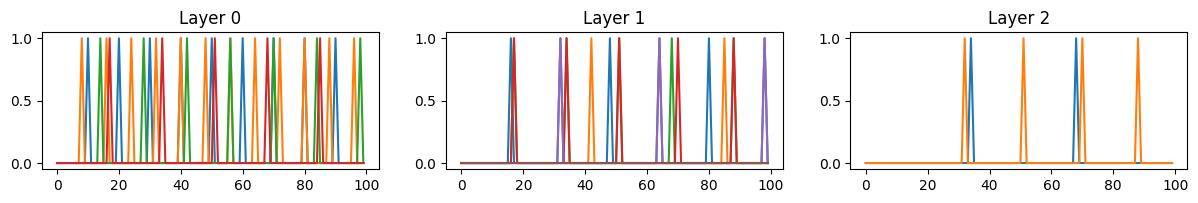

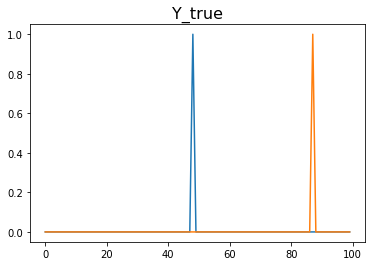

In [0]:
random_evaluate(vector=parents[0][:36], input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=0.1, Cm=5)

##Parallel GA

Generation :  1 / 50
Mean Train Error by entire population: 99.93365958441662
Mean Test Error by entire population: 99.3363233183238

Random evaluation by best parameter found so far:
Evaluation Error: 40.0


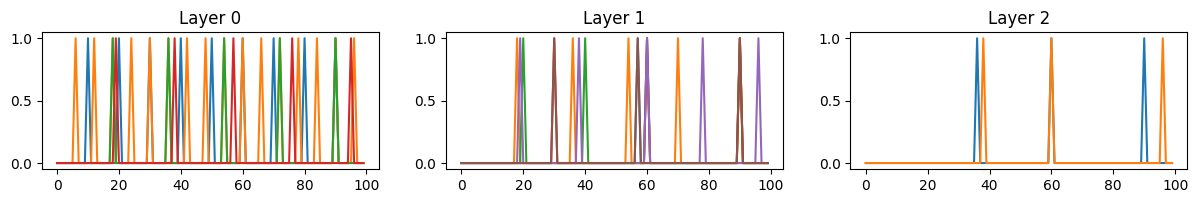

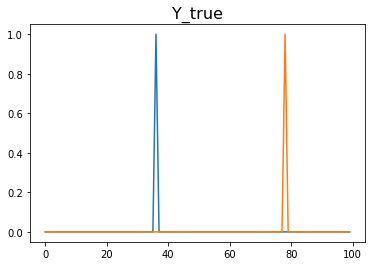

Generation :  2 / 50


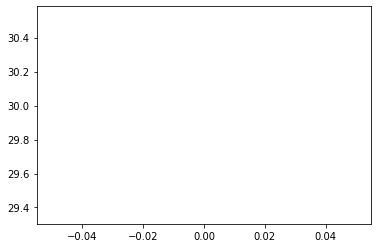

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 138.03032873880557
Mean Test Error by entire population: 138.2360046481509

Random evaluation by best parameter found so far:
Evaluation Error: 6.324555320336759


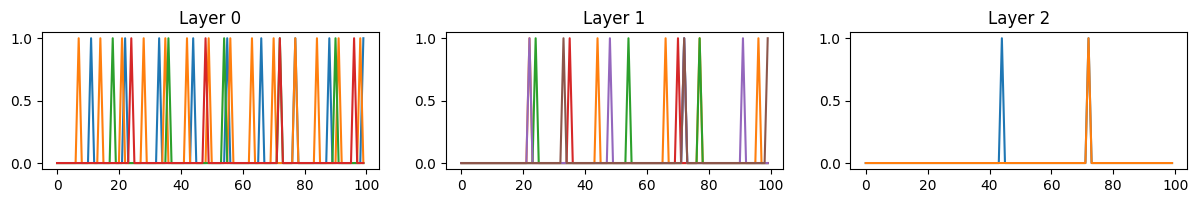

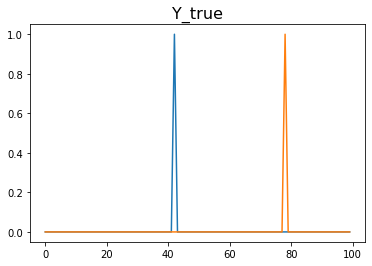

Generation :  3 / 50


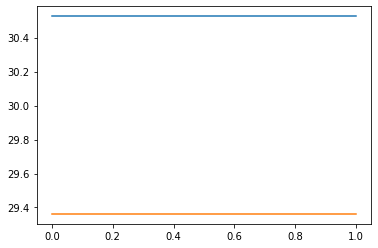

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 137.9188353776758
Mean Test Error by entire population: 137.90744182407616

Random evaluation by best parameter found so far:
Evaluation Error: 9.219544457292887


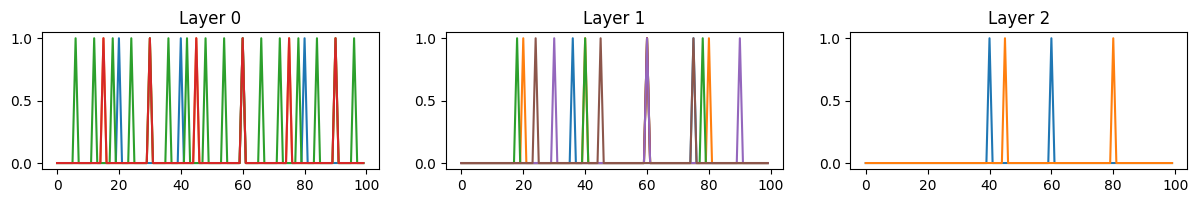

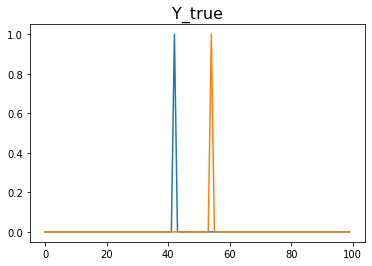

Generation :  4 / 50


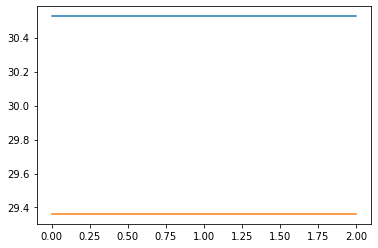

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 150.86341127858253
Mean Test Error by entire population: 150.96948730220117

Random evaluation by best parameter found so far:
Evaluation Error: 19.4164878389476


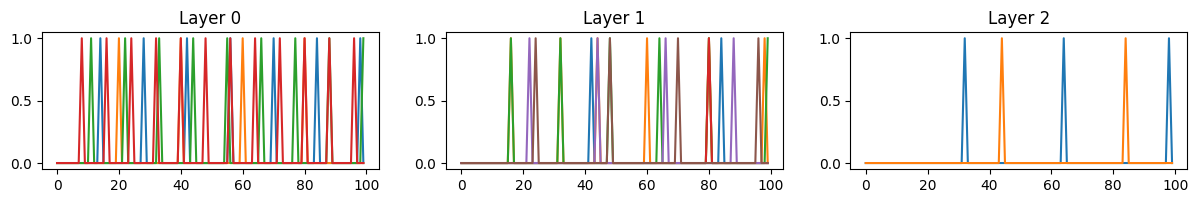

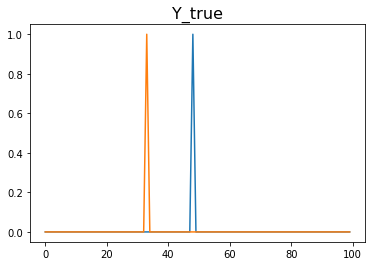

Generation :  5 / 50


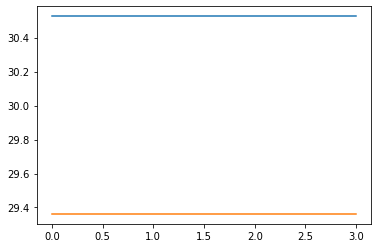

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 143.9789585409456
Mean Test Error by entire population: 144.05508249337825

Random evaluation by best parameter found so far:
Evaluation Error: 20.808652046684813


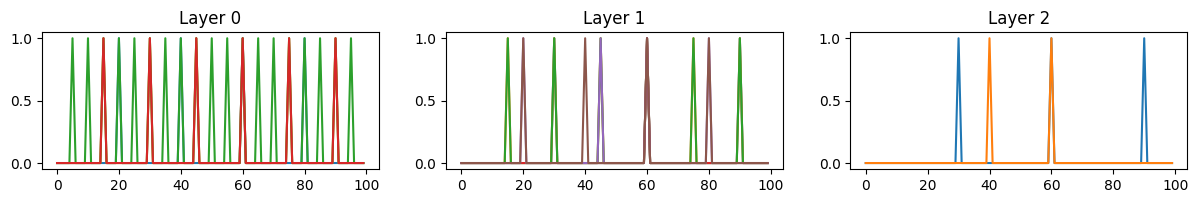

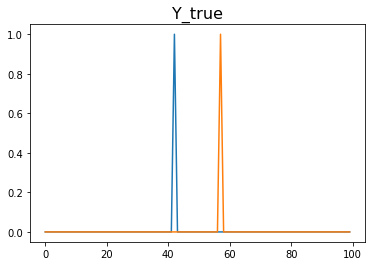

Generation :  6 / 50


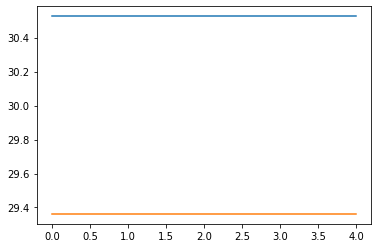

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 149.30150469610834
Mean Test Error by entire population: 149.26130035601588

Random evaluation by best parameter found so far:
Evaluation Error: 48.83646178829912


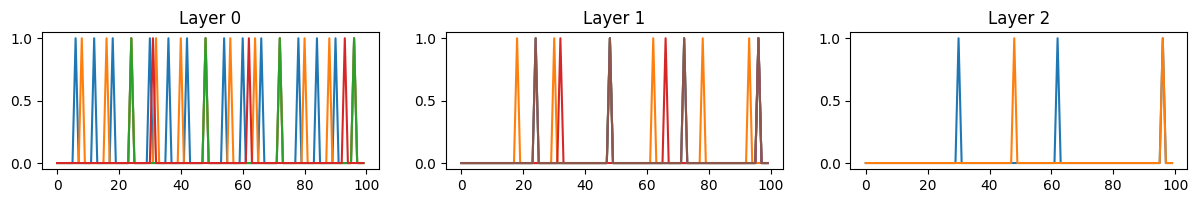

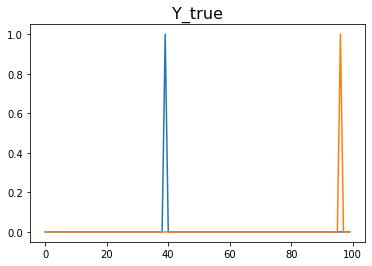

Generation :  7 / 50


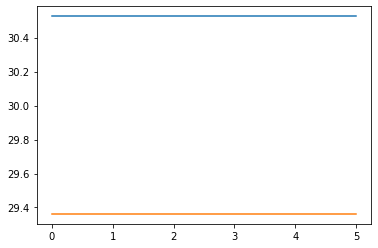

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 131.10287315087598
Mean Test Error by entire population: 130.8670709710918

Random evaluation by best parameter found so far:
Evaluation Error: 50.635955604688654


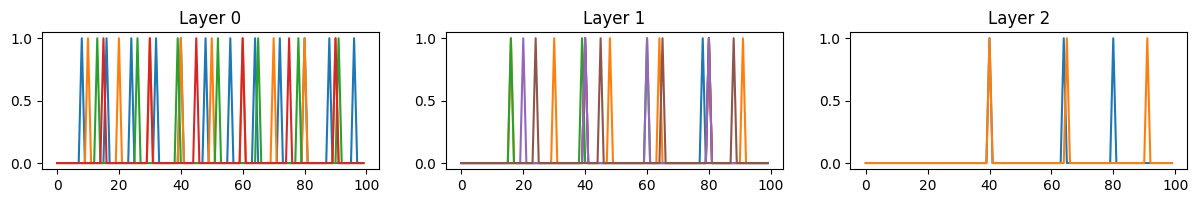

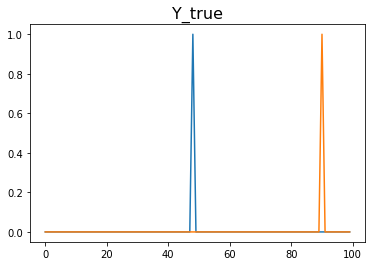

Generation :  8 / 50


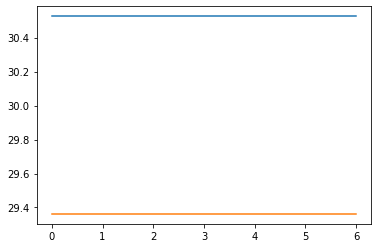

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 146.54980462320523
Mean Test Error by entire population: 146.58933264226042

Random evaluation by best parameter found so far:
Evaluation Error: 14.317821063276353


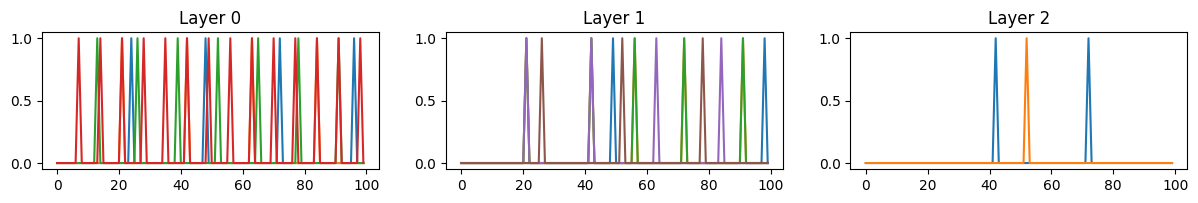

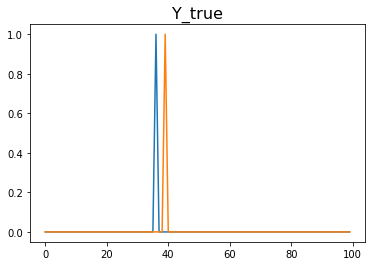

Generation :  9 / 50


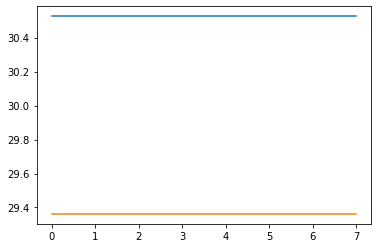

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 144.137442067589
Mean Test Error by entire population: 144.19634479061637

Random evaluation by best parameter found so far:
Evaluation Error: 63.324560795950255


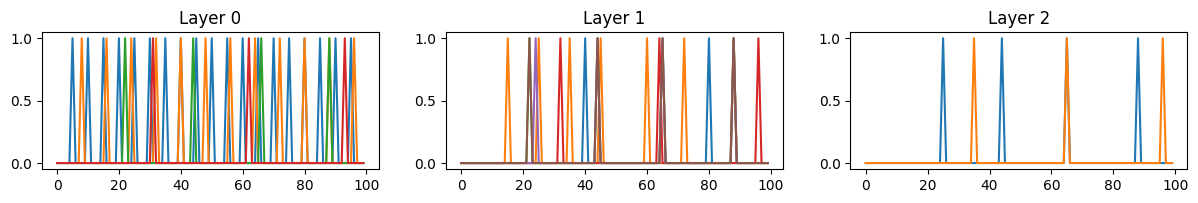

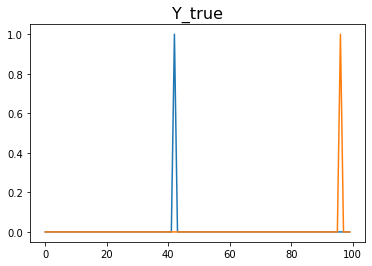

Generation :  10 / 50


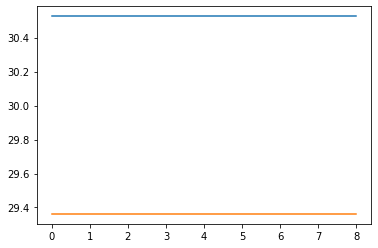

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 149.67013086593877
Mean Test Error by entire population: 149.75895174120222

Random evaluation by best parameter found so far:
Evaluation Error: 45.09988913511872


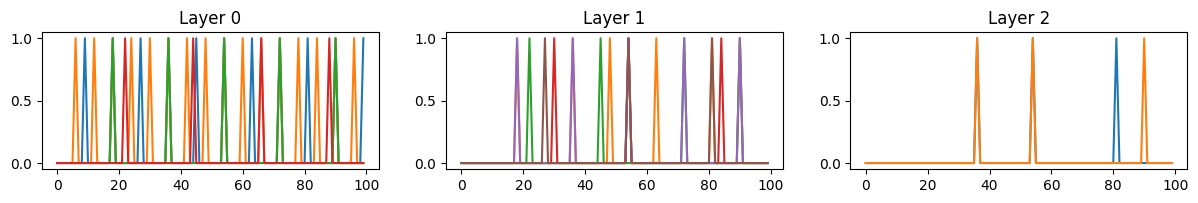

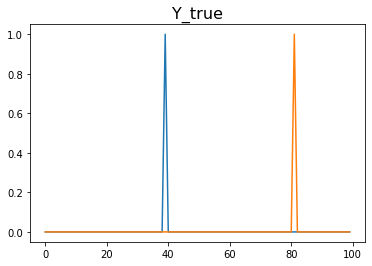

Generation :  11 / 50


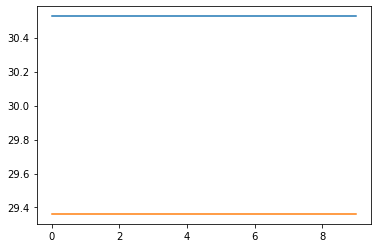

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 132.22283183487298
Mean Test Error by entire population: 132.09024582237308

Random evaluation by best parameter found so far:
Evaluation Error: 24.166091947189145


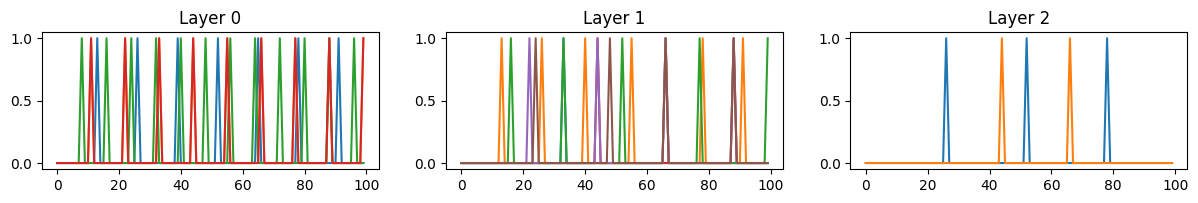

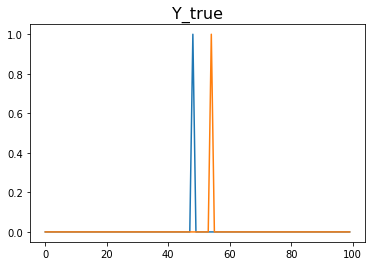

Generation :  12 / 50


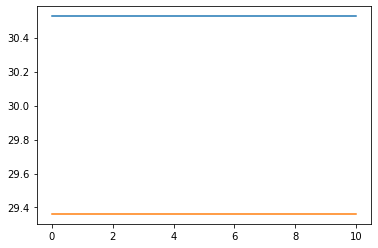

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 132.3607951400576
Mean Test Error by entire population: 132.39198987932315

Random evaluation by best parameter found so far:
Evaluation Error: 16.1245154965971


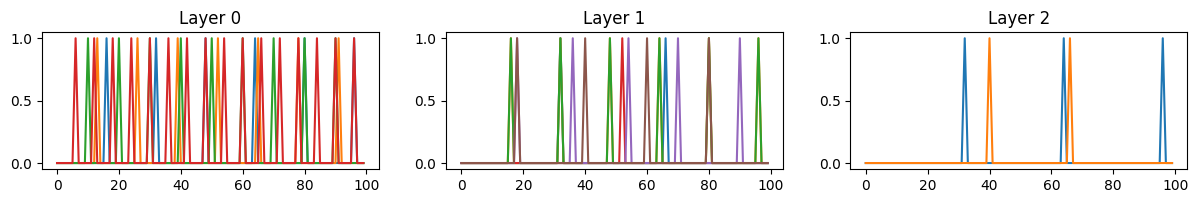

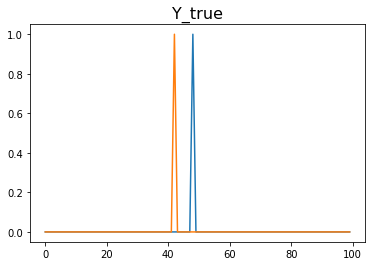

Generation :  13 / 50


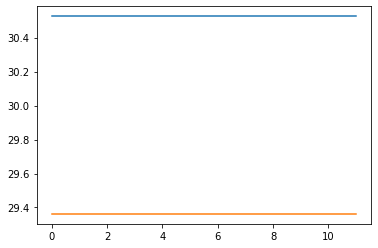

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 143.02785782881398
Mean Test Error by entire population: 142.92732653339155

Random evaluation by best parameter found so far:
Evaluation Error: 12.041594578792296


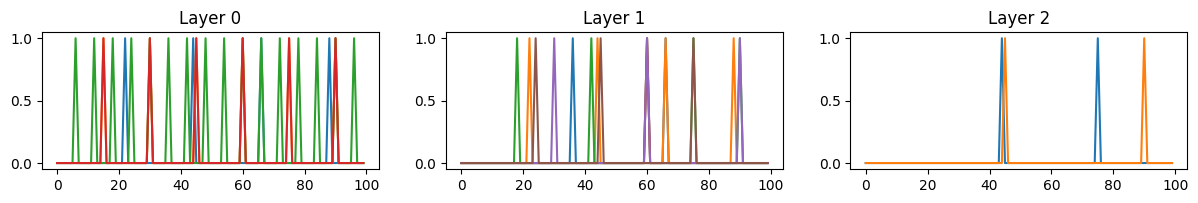

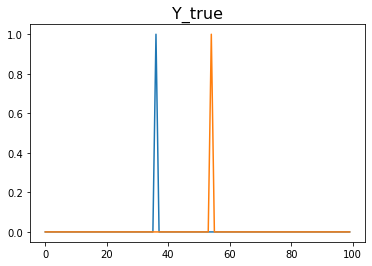

Generation :  14 / 50


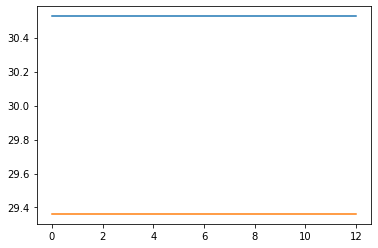

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 148.24180853664967
Mean Test Error by entire population: 148.25818314185193

Random evaluation by best parameter found so far:
Evaluation Error: 10.0


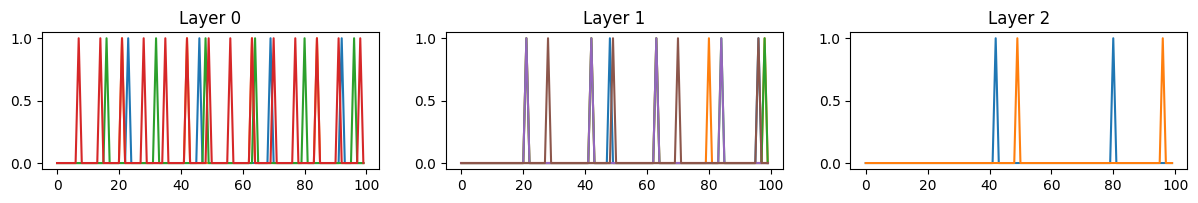

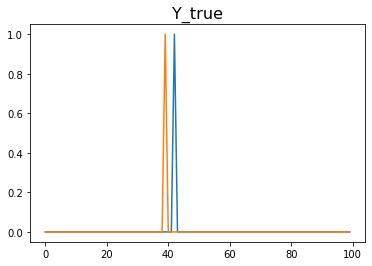

Generation :  15 / 50


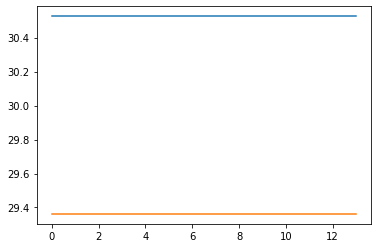

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 135.04642962120985
Mean Test Error by entire population: 135.10030895043417

Random evaluation by best parameter found so far:
Evaluation Error: 45.09988913511872


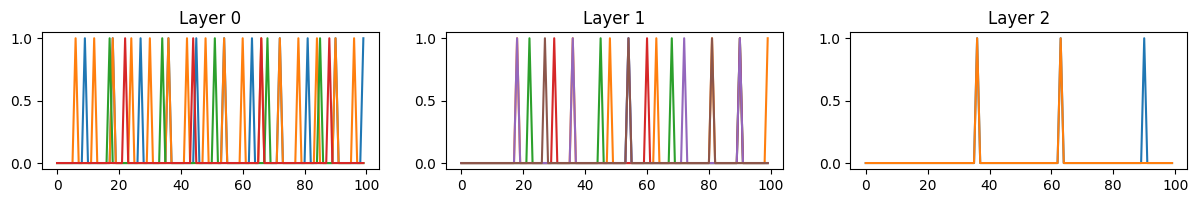

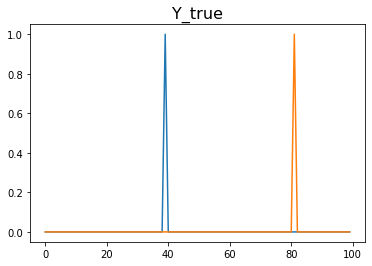

Generation :  16 / 50


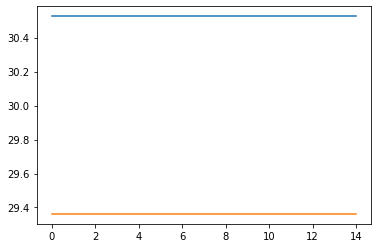

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 148.16420554637645
Mean Test Error by entire population: 148.2024822643776

Random evaluation by best parameter found so far:
Evaluation Error: 35.90264614203248


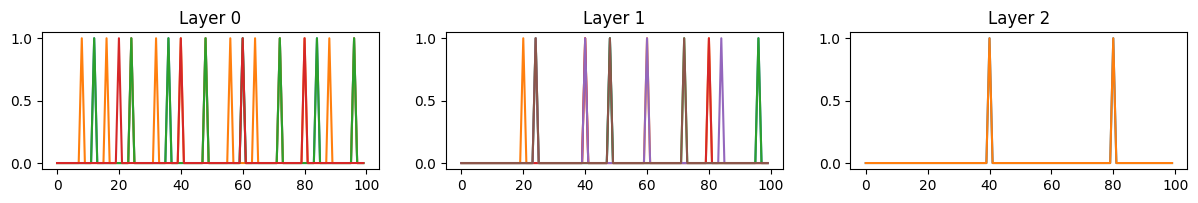

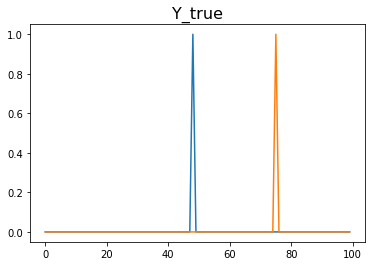

Generation :  17 / 50


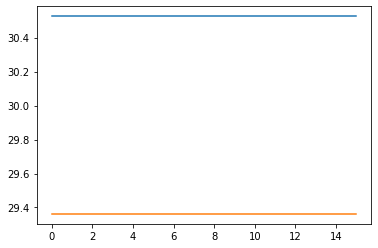

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 142.36046507288225
Mean Test Error by entire population: 142.2339194326328

Random evaluation by best parameter found so far:
Evaluation Error: 21.93171219946131


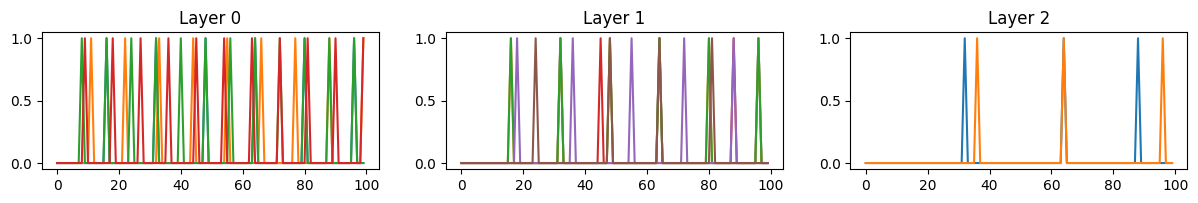

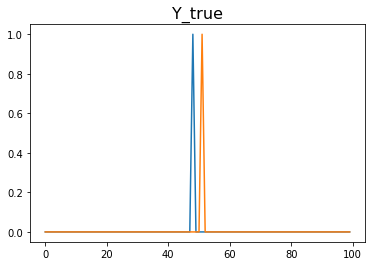

Generation :  18 / 50


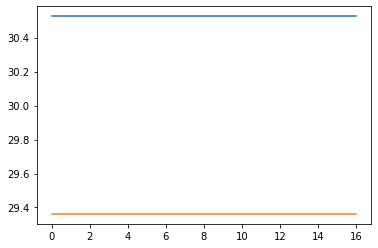

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 141.18918130527027
Mean Test Error by entire population: 141.11759700047858

Random evaluation by best parameter found so far:
Evaluation Error: 20.8806130178211


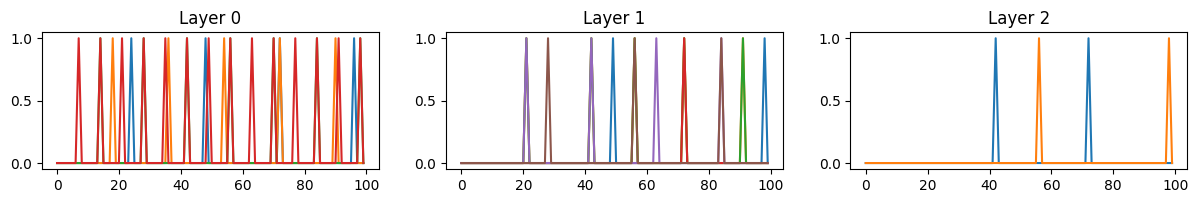

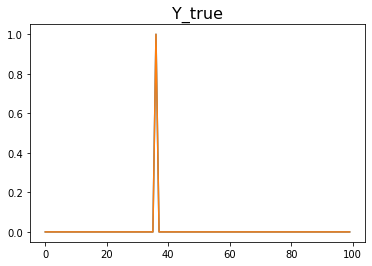

Generation :  19 / 50


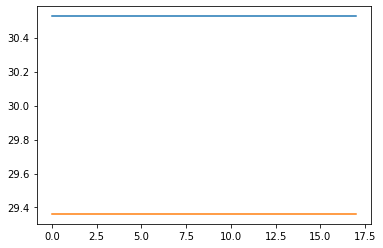

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 137.31342725589823
Mean Test Error by entire population: 137.0819602119184

Random evaluation by best parameter found so far:
Evaluation Error: 17.46424919657298


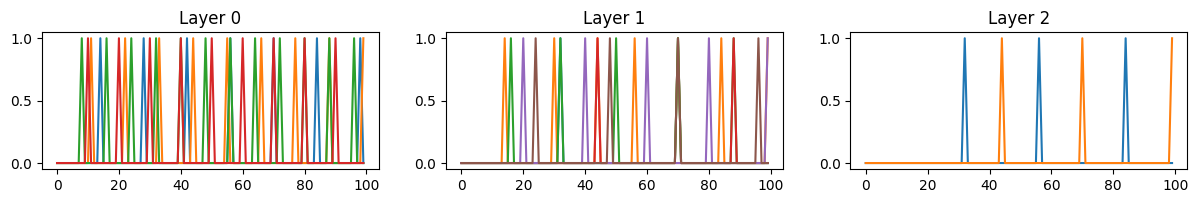

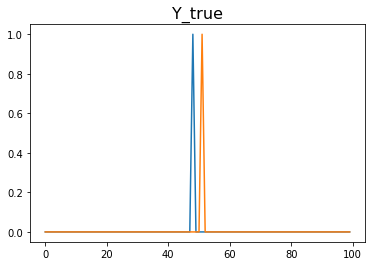

Generation :  20 / 50


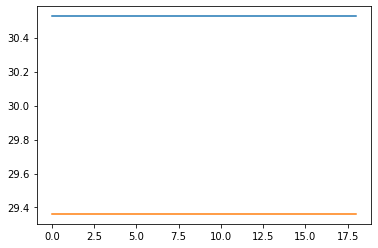

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 136.0891084208409
Mean Test Error by entire population: 136.00665816675536

Random evaluation by best parameter found so far:
Evaluation Error: 10.198039027185569


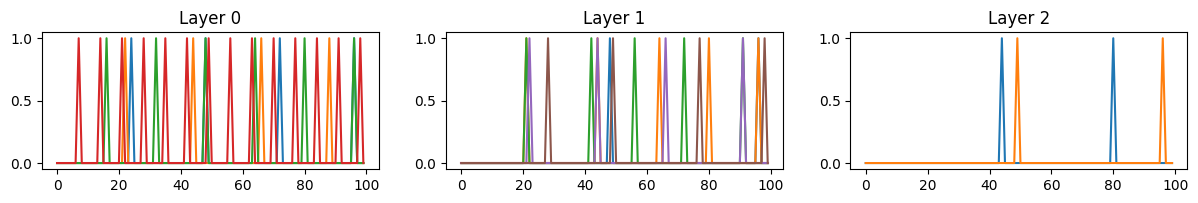

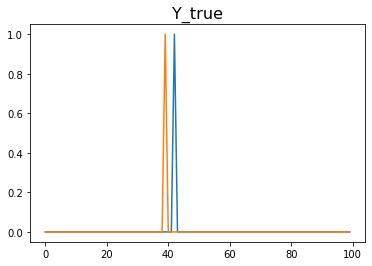

Generation :  21 / 50


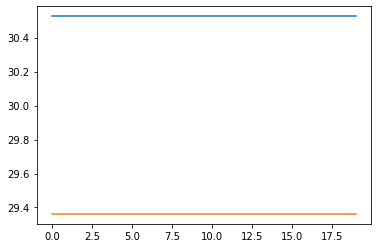

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 151.84738212693136
Mean Test Error by entire population: 151.8933676976245

Random evaluation by best parameter found so far:
Evaluation Error: 6.0


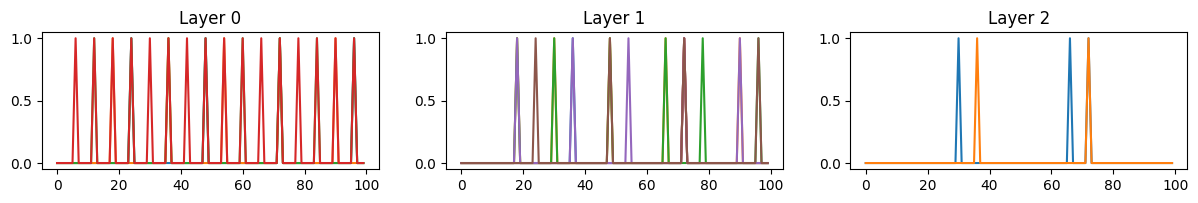

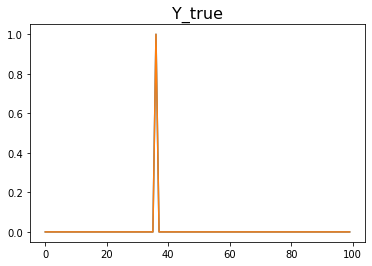

Generation :  22 / 50


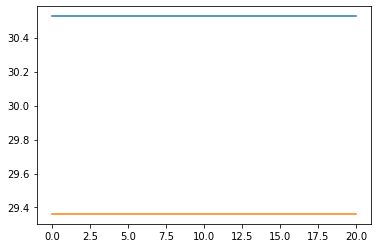

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 140.48332751476178
Mean Test Error by entire population: 140.4514967974271

Random evaluation by best parameter found so far:
Evaluation Error: 59.22837157984339


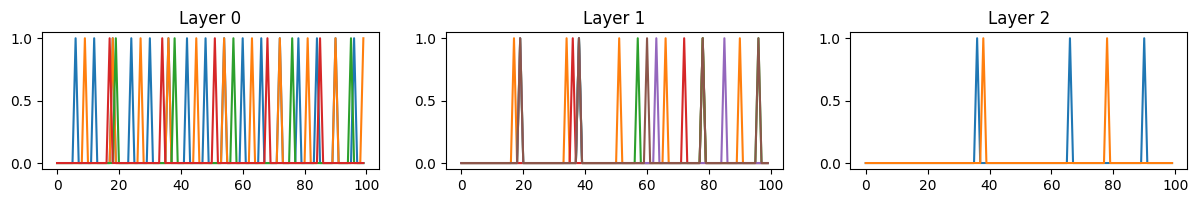

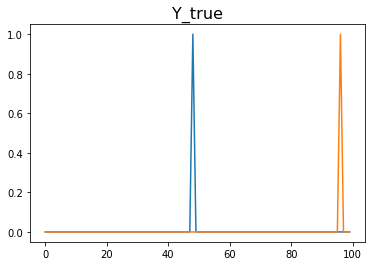

Generation :  23 / 50


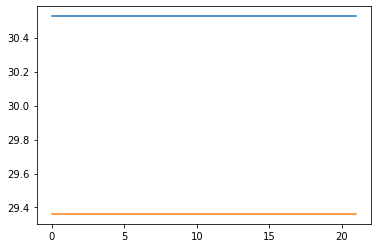

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 141.4873112163663
Mean Test Error by entire population: 141.51827649996136

Random evaluation by best parameter found so far:
Evaluation Error: 38.3275357934736


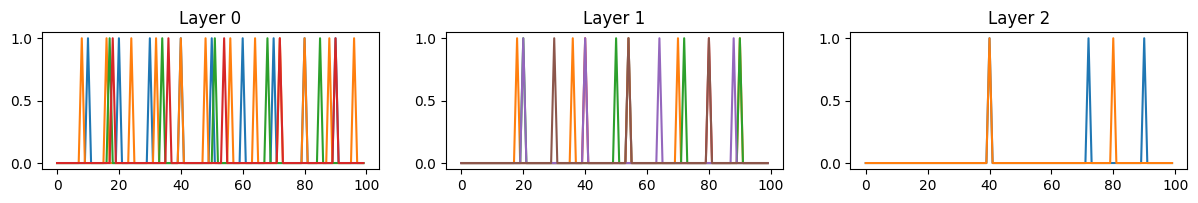

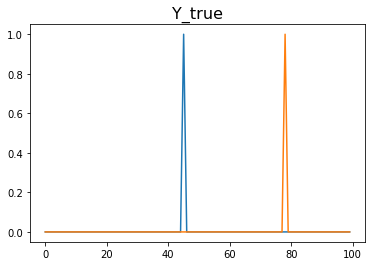

Generation :  24 / 50


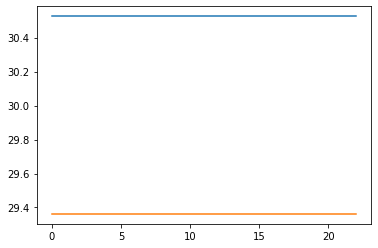

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 151.9810511270295
Mean Test Error by entire population: 152.00649828780652

Random evaluation by best parameter found so far:
Evaluation Error: 56.92099788303083


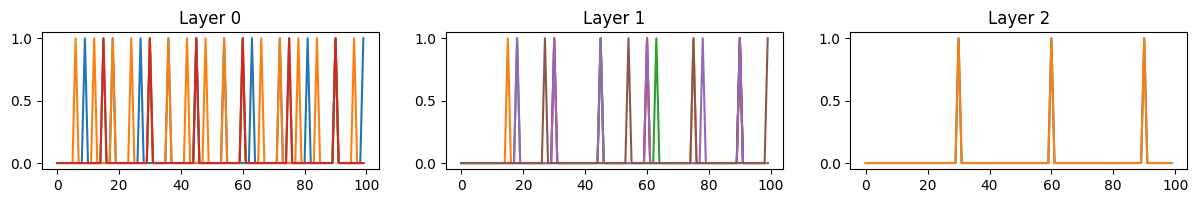

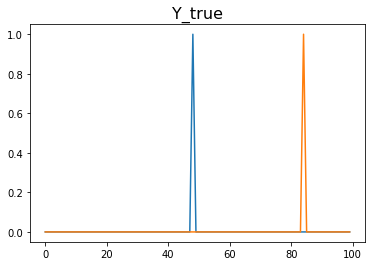

Generation :  25 / 50


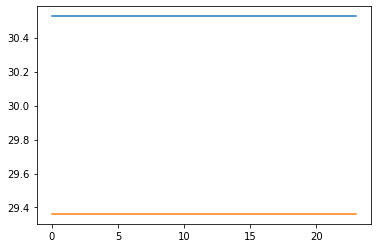

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 143.06779280730703
Mean Test Error by entire population: 142.9654438753795

Random evaluation by best parameter found so far:
Evaluation Error: 14.317821063276353


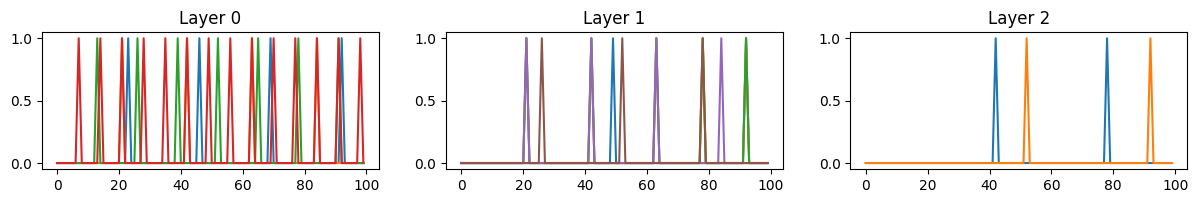

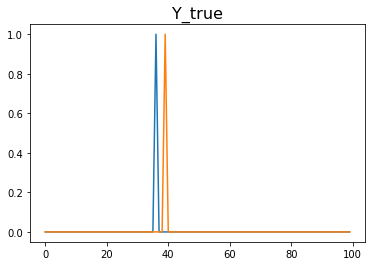

Generation :  26 / 50


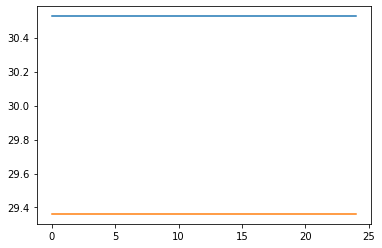

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 151.25762676787687
Mean Test Error by entire population: 151.35509738017515

Random evaluation by best parameter found so far:
Evaluation Error: 49.36598018878993


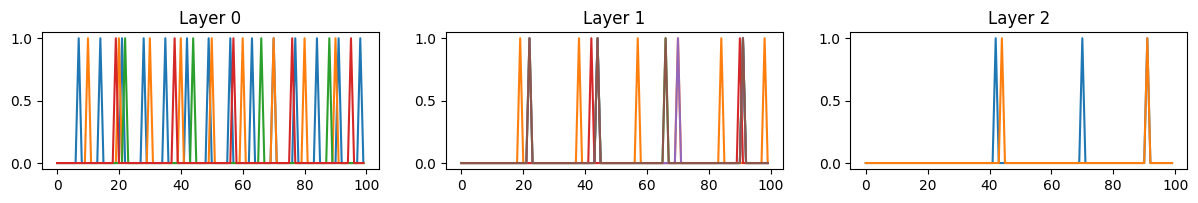

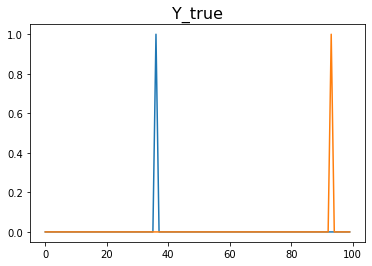

Generation :  27 / 50


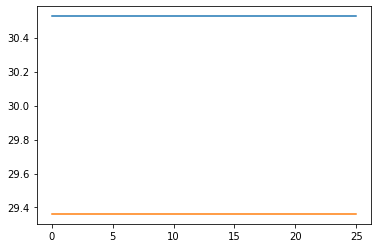

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 133.39232472106
Mean Test Error by entire population: 133.47938686724126

Random evaluation by best parameter found so far:
Evaluation Error: 19.697715603592208


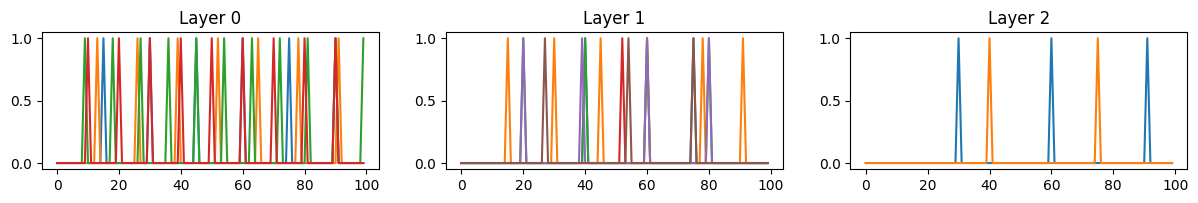

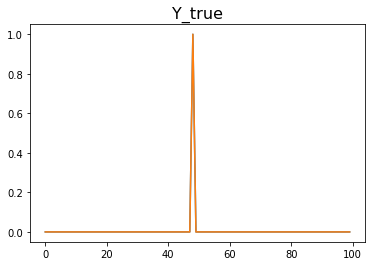

Generation :  28 / 50


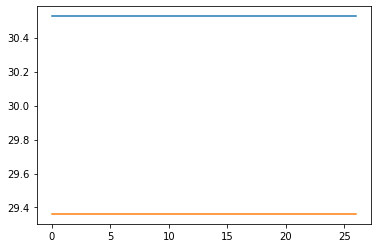

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 132.9717156717846
Mean Test Error by entire population: 132.80926824248132

Random evaluation by best parameter found so far:
Evaluation Error: 52.80151512977634


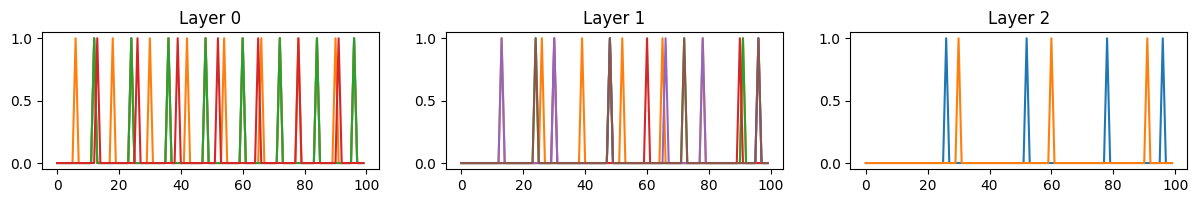

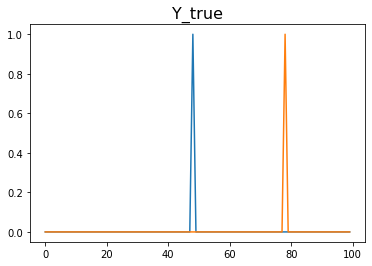

Generation :  29 / 50


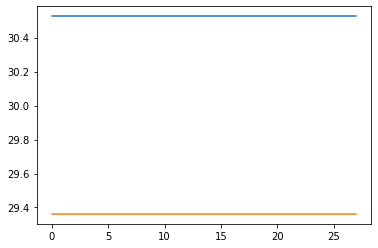

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 131.64767481795437
Mean Test Error by entire population: 131.5475493995772

Random evaluation by best parameter found so far:
Evaluation Error: 31.240998703626616


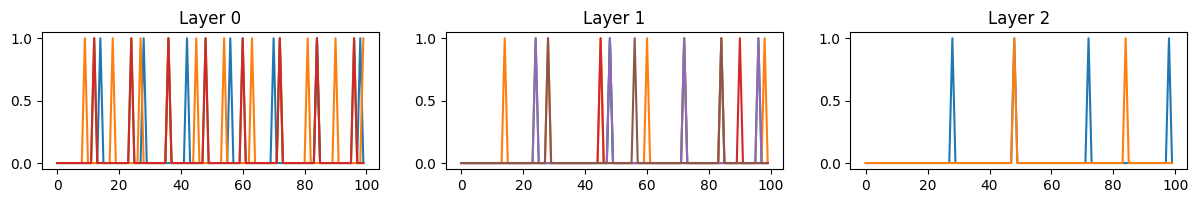

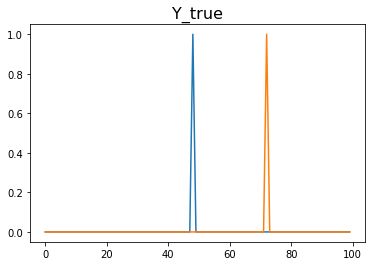

Generation :  30 / 50


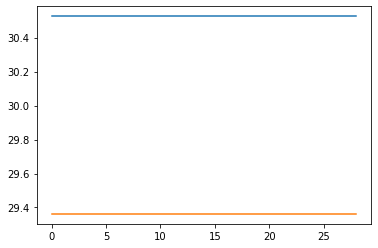

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 149.99089460190456
Mean Test Error by entire population: 150.14825667426808

Random evaluation by best parameter found so far:
Evaluation Error: 19.4164878389476


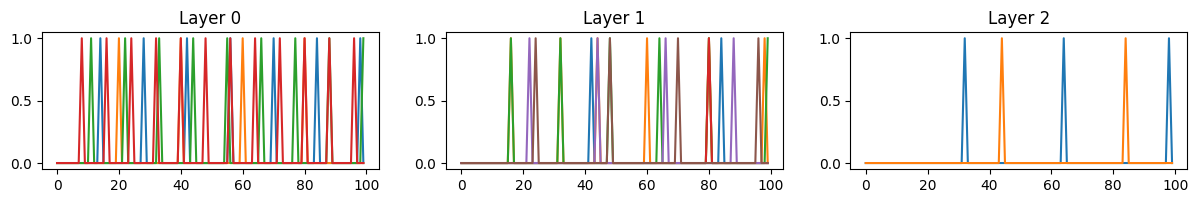

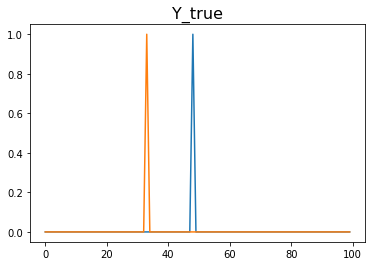

Generation :  31 / 50


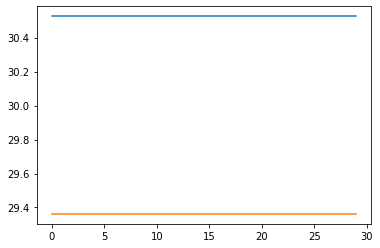

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 140.3770047431511
Mean Test Error by entire population: 140.25448825205814

Random evaluation by best parameter found so far:
Evaluation Error: 52.23983154643591


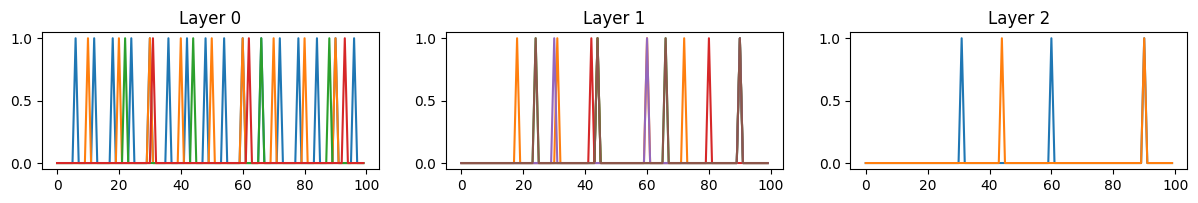

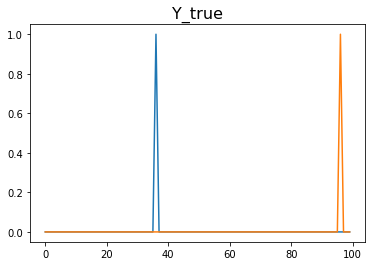

Generation :  32 / 50


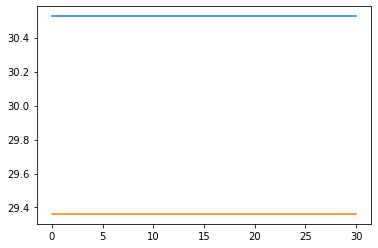

Mean Train Error by best parameters found: 30.525919529331425
Mean Test Error by best parameters found: 29.362166907578192

Mean Train Error by entire population: 141.28314559714408
Mean Test Error by entire population: 141.27073150255154

Random evaluation by best parameter found so far:
Evaluation Error: 13.416407864998739


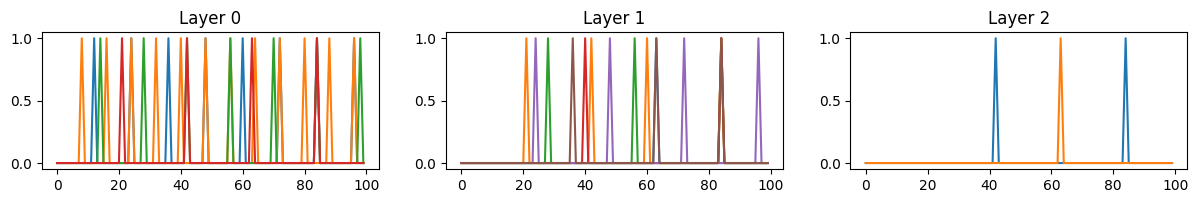

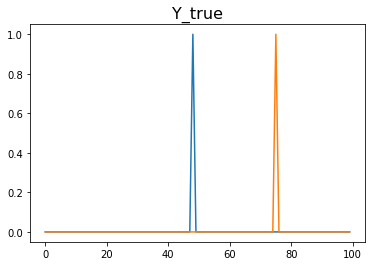

Process Process-966:
Process Process-961:
Process Process-964:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Process-962:
Process Process-974:
Process Process-985:
Process Process-982:
Process Process-977:
Process Process-979:
Process Process-968:
Process Process-973:
Process Process-987:
Process Process-965:
Process Process-989:
Process Process-981:
Process Process-983:
Process Process-986:
Process Process-976:
Process Process-967:
Process Process-972:
Process Process-963:
Process Process-978:
Process Process-980:
Process Process-970:
Process Process-988:
Process Process-971:
Process Process-984:
Process Process-969:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-990:
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-53607bc217cc>", line 43, in <module>
    p.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling o

KeyboardInterrupt: ignored

In [0]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters
sol_per_pop = 30
num_parents_mating = 10
num_generations = 50
mutation_percent = 20
ga = GA()

#Neuron parameters
input_dim=4
neurons_per_layer=[6,2]

#initial population :       
initial_synapses = np.random.uniform(0, 1.5,size=(sol_per_pop, 36)) #4*6 + 6*2 = 36(synapses) + 1 (Cm) + 1 (Threshold)
initial_Cms = np.random.randint(1,6,size=(sol_per_pop,1))
initial_thresholds = np.random.uniform(0.05, 0.3, size=(sol_per_pop, 1))

population_vectors = np.hstack((initial_synapses, initial_Cms, initial_thresholds)) #36+1+1

best_train_error, best_test_error = [], []
pop_train_error, pop_test_error = [], []

for generation in range(num_generations):

    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(sol_per_pop).reshape(sol_per_pop,1)))
    
    processes=[]
    for c in temp_population_vectors:
        syn = c[:36]
        Cm = c[36]
        th = c[37]
        p_id = c[38]
        p = mp.Process(target = mp_fitness, args=([syn, Cm, th, p_id], output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column

    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])
    
    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    #print(parents.shape[0],'New parents generated...')
    
    #Crossover parents : according to modality
    synapse_offsprings = ga.crossover(parents=parents[:,:36], num_offsprings=sol_per_pop-num_parents_mating)
    Cm_offsprings = ga.crossover(parents=parents[:,36], num_offsprings=sol_per_pop-num_parents_mating).reshape(-1,1)
    threshold_offsprings = ga.crossover(parents=parents[:,37], num_offsprings=sol_per_pop-num_parents_mating).reshape(-1,1)
    
    offsprings = np.hstack((synapse_offsprings, Cm_offsprings, threshold_offsprings))
    #print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings : according to modality
    mutated_synapse_offsprings = ga.mutate(offsprings[:,:36], perturbation_range=[-1.,1.], mutation_percent=mutation_percent)
    mutated_Cm_offsprings = ga.mutate(offsprings[:,36], perturbation_range=[-1,1], mutation_percent=mutation_percent).reshape(-1,1)
    mutated_threshold_offsprings = ga.mutate(offsprings[:,37], perturbation_range=[-0.01,0.01], mutation_percent=mutation_percent).reshape(-1,1)

    mutated_Cm_offsprings[mutated_Cm_offsprings==0] = 1                     #Avoid the case where Cm becomes 0
    mutated_threshold_offsprings[mutated_threshold_offsprings==0] = 0.01    #Avoid the case where threshold becomes 0

    mutated_offsprings = np.hstack((mutated_synapse_offsprings, mutated_Cm_offsprings, mutated_threshold_offsprings))
    #print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    #print('New population created')

    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    if generation != 0:                                             #Ignore first generation since parents are not sorted
        best_train_error.append(fitness_train[0])                   #Mean error by best parameters
        best_test_error.append(fitness_test[0])                     #mean error by best parameters
        plt.plot(best_train_error)
        plt.plot(best_test_error)
        plt.show()       
        print('Mean Train Error by best parameters found:', best_train_error[-1])
        print('Mean Test Error by best parameters found:', best_test_error[-1])
        print()
        #Update the result of this generation in report files
        '''
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
        pickle.dump(best_train_error, f)
        f.close()
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
        pickle.dump(best_test_error, f)
        f.close()  
        '''      
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/(4)best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()
    
    pop_train_error.append(np.mean(fitness_train))              #Mean error by whole population
    pop_test_error.append(np.mean(fitness_test))                #mean error by whole population
    print('Mean Train Error by entire population:', pop_train_error[-1])
    print('Mean Test Error by entire population:', pop_test_error[-1])
    print()
    print('Random evaluation by best parameter found so far:')
    random_evaluate(vector=parents[0][:36], input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=parents[0][37], Cm=parents[0][36])